In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('../bitome-kb/bitome.pkl')

In [2]:
from feature_functions import *
from pymodulon.io import load_json_model
from pymodulon.visualization import *

The name visualization is deprecated. Please use plotting


In [3]:
bitome.operons[0].location

FeatureLocation(ExactPosition(4634440), ExactPosition(4635382), strand=-1)

# load shape data

In [4]:
shape_table = pd.read_pickle('../../K12DNA_structure/ecoli_U00096/ecoli_U00096_shape.pickle')

In [5]:
get_shape(10,20,shape_table)

,HelT,Roll,Shift,Slide,Rise,TilT,Buckle,Shear,Stretch,Stagger,Opening,MGW,ProT,EP,loc
10,34.325,-4.875,-0.030,-1.385,3.235,0.670,-4.13,-0.15,-0.02,-0.03,-1.00,4.39,-9.43,-8.53,10
11,36.200,-2.365,0.215,-1.375,3.320,-0.445,0.42,-0.08,-0.03,-0.29,-0.39,4.43,-10.15,-8.34,11
12,33.985,-1.405,0.030,-1.605,3.390,-0.380,-3.69,0.26,-0.03,0.13,0.05,5.14,-3.52,-5.96,12
13,32.910,1.335,0.005,-1.535,3.340,0.885,-0.55,-0.10,-0.03,-0.05,-0.72,5.47,-6.32,-6.97,13
14,34.775,1.485,0.035,-1.420,3.295,0.070,-1.24,-0.28,-0.04,0.02,0.27,5.67,-6.43,-5.23,14
15,35.015,-2.205,0.030,-1.555,3.340,-0.680,2.75,0.11,-0.02,-0.02,-0.23,4.89,-8.11,-7.61,15
16,33.170,-2.145,0.010,-1.680,3.390,0.315,0.06,0.25,-0.02,0.12,0.33,5.00,-3.96,-5.57,16
17,32.855,1.070,0.040,-1.560,3.325,0.735,1.05,-0.11,-0.03,-0.13,-0.54,5.40,-7.79,-6.89,17
18,34.895,1.290,0.130,-1.485,3.345,-0.670,-0.33,-0.26,-0.04,0.12,0.26,5.79,-3.68,-5.00,18
19,35.130,1.830,-0.235,-1.360,3.345,1.095,0.73,0.25,-0.04,0.14,0.20,5.78,-3.80,-5.27,19


# load IM membership

In [4]:
import pymodulon

In [5]:
precise2 = load_json_model('data/precise2.json.gz')
im_table = precise2.imodulon_table
regulatory_ims = im_table[im_table['regulator'].notna()]

In [7]:
S = precise2.M
#S.to_csv('data/S.csv')

In [8]:
regulatory_ims.head()

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,category,exp_var,trn_enrich_params,note
CysB-1,CysB,0.000000e+00,1.980000e-07,0.411765,0.225806,0.291667,7.0,17.0,31,1.0,NaN,Regulatory,0.964488,None,None
HprR+CusR,HprR+CusR,4.190000e-16,0.000000e+00,0.857143,0.545455,0.666667,6.0,7.0,11,2.0,NaN,Regulatory,0.795047,None,None
PhoB-1,PhoB,1.190000e-17,0.000000e+00,0.191489,0.900000,0.315789,9.0,47.0,10,1.0,NaN,Regulatory,0.103377,None,None
Fnr-1,Fnr,7.500000e-24,2.840000e-19,0.207921,0.488372,0.291667,21.0,101.0,43,1.0,NaN,Regulatory,1.230918,None,None
TdcAR,TdcR+TdcA+IHF+Crp,1.710000e-19,0.000000e+00,1.000000,0.583333,0.736842,7.0,7.0,12,4.0,NaN,Regulatory,0.510933,max_regs=4,None


Text(0, 0.5, 'precision / recall')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


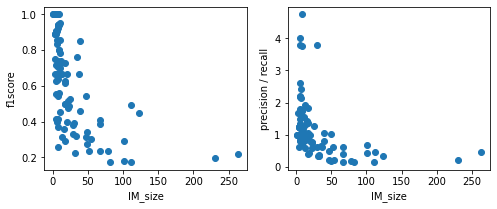

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
axs[0].scatter(regulatory_ims['regulon_size'],regulatory_ims['f1score'])
axs[0].set_xlabel('IM_size')
axs[0].set_ylabel('f1score')
pre_d_rec = [ (regulatory_ims['precision'][i]/regulatory_ims['recall'][i]) for i in range(len(regulatory_ims['precision']))]
axs[1].scatter(regulatory_ims['regulon_size'],pre_d_rec)
axs[1].set_xlabel('IM_size')
axs[1].set_ylabel('precision / recall')

Text(0, 0.5, 'f1score')

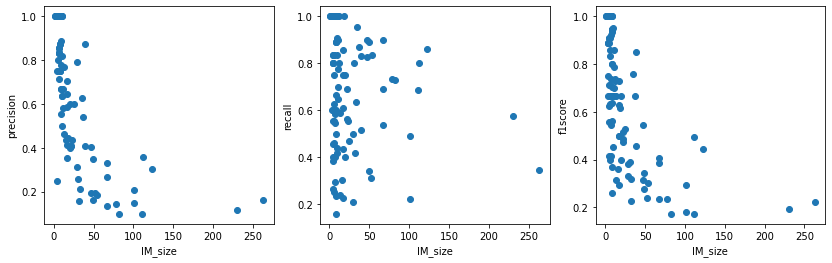

In [11]:
fig,axs = plt.subplots(1,3,figsize=(14,4))
axs[0].scatter(regulatory_ims['regulon_size'],regulatory_ims['precision'])
axs[0].set_xlabel('IM_size')
axs[0].set_ylabel('precision')
axs[1].scatter(regulatory_ims['regulon_size'],regulatory_ims['recall'])
axs[1].set_xlabel('IM_size')
axs[1].set_ylabel('recall')
axs[2].scatter(regulatory_ims['regulon_size'],regulatory_ims['f1score'])
axs[2].set_xlabel('IM_size')
axs[2].set_ylabel('f1score')

In [8]:
TRN = precise2.trn
TRN = TRN[TRN['evidence'].notna()]

In [9]:
im_names = list(regulatory_ims.index)
tf = list(regulatory_ims['regulator'] )

gene_list = []
im_size = []
for im in im_names:
    genes = list( precise2.view_imodulon(im).index )
    gene_list.append( genes )
    im_size.append( len(genes) )

In [10]:
p_im_db = pd.DataFrame( list(zip(im_names, tf, gene_list,im_size)), columns =['im_name', 'tf','genes','size'])
p_im_db.to_csv('data/precise2_im_info_new.csv',index=None)

## IM membership

In [6]:
import ast
im_info = pd.read_csv('data/precise2_im_info_new.csv')

In [7]:
im_info.head()

,im_name,tf,genes,size
0,CysB-1,CysB,"['b0828', 'b0829', 'b0830', 'b1287', 'b1729', ...",31
1,HprR+CusR,HprR+CusR,"['b0123', 'b0484', 'b0570', 'b0571', 'b0572', ...",11
2,PhoB-1,PhoB,"['b0241', 'b0383', 'b0399', 'b0400', 'b3723', ...",10
3,Fnr-1,Fnr,"['b0894', 'b0895', 'b0896', 'b0903', 'b1127', ...",43
4,TdcAR,TdcR+TdcA+IHF+Crp,"['b0114', 'b2579', 'b4471', 'b3113', 'b3114', ...",12


In [8]:
IM_genes = {}
for i in range(len(im_info['im_name'])):
    IM_genes[im_info['im_name'][i]] = ast.literal_eval( im_info['genes'][i] )
IM_genes.keys()

dict_keys(['CysB-1', 'HprR+CusR', 'PhoB-1', 'Fnr-1', 'TdcAR', 'Fimbriae', 'PurR-2', 'Fnr+NarL', 'GalRS', 'BtsR', 'PyrR', 'PlaR', 'RpoN+FhlA', 'RhaS', 'NanR', 'FadR', 'NrdR', 'GlcC', 'BaeR+CpxR', 'NikR', 'Isoleucine', 'RpoN+PspF', 'OxyR', 'TrpR', 'CsqR', 'LldR', 'Thiamine-1', 'PuuR', 'YcjW', 'PdhR+OmpR', 'NsrR', 'GntR', 'Fnr+NarLP', 'RcsAB', 'MalT', 'TyrR', 'Molybdopterin', 'Fnr-2', 'AtoC', 'Leucine', 'SoxS', 'Translation', 'RcnR', 'Lrp', 'Nac', 'KdpE', 'PhoB-2', 'RbsR', 'CysB-2', 'FlhDC-1', 'GatR', 'ArgR', 'GadX', 'RpoN+NtrC-1', 'XylR', 'ArcA', 'BirA', 'EvgA', 'BluR', 'LsrR', 'Zur', 'RpoE', 'Fur-1', 'PurR-1', 'ArgP', 'AllR', 'FucR', 'Fur-2', 'Mlc', 'CecR', 'Fnr+IHF+gcvB', 'YgbI', 'LexA', 'Cra', 'GlpR', 'RpoN+NtrC-2', 'PaaX', 'Oligopeptide', 'CdaR', 'RpoN+PrpR+Cra', 'FliA', 'CpxR', 'Histidine', 'RpoH', 'GadE+FliZ', 'GcvA', 'YdeO+H-NS', 'NagC', 'GutM+SrlR', 'MetJ', 'RpoS', 'CysB-3', 'FlhDC-2', 'RutR', 'PhoP', 'RyhB', 'BasR', 'NarL', 'RpoS+ArgR+RpoN', 'Crp-related-2'])

## generate PWMs

In [9]:
prib_sig = {'Sigma70':[],'Sigma32':[],'Sigma38':[],'Sigma24':[],'Sigma28':[],'Sigma54':[]}
m35_sig = {'Sigma70':[],'Sigma32':[],'Sigma38':[],'Sigma24':[],'Sigma28':[],'Sigma54':[]}
for p in bitome.promoters:
    for k in prib_sig.keys():
        if p.sigma_factors == [k]:
            if p.box_10_location != None:
                prib_sig[k].append(p)
            if p.box_35_location != None:
                m35_sig[k].append(p)
                
M_prib = {'Sigma70':[],'Sigma32':[],'Sigma38':[],'Sigma24':[],'Sigma28':[],'Sigma54':[]}
M_m35 = {'Sigma70':[],'Sigma32':[],'Sigma38':[],'Sigma24':[],'Sigma28':[],'Sigma54':[]}
for k in M_prib.keys():
    if k == 'Sigma70':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]
    elif k == 'Sigma32':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(7)]
    elif k == 'Sigma38':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(11)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]
    elif k == 'Sigma24':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(7)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(7)]
    elif k == 'Sigma28':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(8)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]
    elif k == 'Sigma54':
        M_prib[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(5)]
        M_m35[k] = [{'A': 0, 'C':0, 'G':0, 'T':0} for i in range(6)]

for k in M_prib.keys():
    for p in prib_sig[k]:
        if int(p.box_10_location.strand) == -1:
            s = complement(revstrand( str(bitome.sequence)[ int(p.box_10_location.start):int(p.box_10_location.end)] ))
        else:
            s = str(bitome.sequence)[ int(p.box_10_location.start):int(p.box_10_location.end)]
           
        if len(s) != len(M_prib[k]):
            continue
            
        for i in range(len(s)):
            M_prib[k][i][s[i]] = M_prib[k][i][s[i]] + 1
        
        if int(p.box_35_location.strand) == -1:
            s2 = complement(revstrand( str(bitome.sequence)[ int(p.box_35_location.start):int(p.box_35_location.end)] ))
        else:
            s2 = str(bitome.sequence)[ int(p.box_35_location.start):int(p.box_35_location.end)]
            
        if len(s2) != len(M_m35[k]):
            continue
            
        for i in range(len(s2)):
            M_m35[k][i][s2[i]] = M_m35[k][i][s2[i]] + 1          
            
for k in M_prib.keys():
    for i in range(len(M_prib[k])):
        SUM = M_prib[k][i]['A']+M_prib[k][i]['C']+M_prib[k][i]['G']+M_prib[k][i]['T']+4 # avoid log(0)
        for nu in ['A','C','G','T']:
            M_prib[k][i][nu] = log( (M_prib[k][i][nu]+1)/ SUM )
                    
for k in M_m35.keys():
    for i in range(len(M_m35[k])):
        SUM = M_m35[k][i]['A']+M_m35[k][i]['C']+M_m35[k][i]['G']+M_m35[k][i]['T'] + 4
        for nu in ['A','C','G','T']:
            M_m35[k][i][nu] = log( (M_m35[k][i][nu]+1)/ SUM )
            
M_prib['Sigma38'] = M_prib['Sigma38'][4:11]

In [10]:
m10_seq = { 'Sigma70':'TATAAT','Sigma38':'CTATACT','Sigma32':'CCCCAT','Sigma24':'TGTCAAA','Sigma28':'GCCGATAA','Sigma54':'TGCAT'}
m35_seq = { 'Sigma70':'TTGACA','Sigma38':'TTGACA','Sigma32':'CTTGAAA','Sigma24':'TGAACTT','Sigma28':'CTAAAG','Sigma54':'TGGCAC'}

In [12]:
sigma_pssm = {}
sigma_pssm['M_prib'] = M_prib
sigma_pssm['M_m35'] = M_m35
sigma_pssm['m10_seq'] = m10_seq
sigma_pssm['m35_seq'] = m35_seq
# save sigma factor PSSM
import pickle 
file = open("data/sigma_pssm_ecoli.txt", "wb")
pickle.dump( sigma_pssm , file) 
file.close()

### Load Sigma PSSM

In [13]:
# reading the data from the file 
with open('data/sigma_pssm_ecoli.txt', 'rb') as handle: 
    data = handle.read()  
# reconstructing the data as dictionary 
d = pickle.loads(data)
M_prib = d['M_prib']
M_m35 = d['M_m35']
m10_seq = d['m10_seq']
m35_seq = d['m35_seq']

###  Load TF and IM motifs

In [14]:
pwm_db = rpwm('data/motif_pwm_db.txt')
pwm_im = rlogodds('data/motif_logodds.txt')
IM_motif_to_use = list( set(pwm_im.keys())&set(IM_genes.keys()) )

tf_genes = ['araC', 'arcA', 'argR','argP','baeR','basR','cysB', 'cpxR', 'cra',
       'crp', 'mlc','mqsA' ,'evgA', 'exuR', 'fadR','iclR','ihfA','ihfB','iscR','fhlA','flhD','flhC', 'fnr',
       'fur','gadE','gadW','gadX','galR','galS','gcvA', 'glpR','glrR','gntR', 'tyrR','lexA','leuO',
        'lrp', 'malT', 'metJ','nac', 'nagC','nanR' ,'narL','narP','nrdR','nsrR',
        'glnG','ompR','oxyR','pdhR','phoB','phoP','purR', 'puuR', 'rcsA','rcsB','rhaS','rutR','soxS', 'trpR', 'xylR','ydeO']

In [15]:
tf_list =['AraC', 'ArcA', 'ArgP', 'ArgR', 'BaeR', 'BasR', 'CysB', 'CpxR', 
          'Cra', 'CRP', 'Mlc', 'MqsA', 'EvgA', 'ExuR', 'FadR', 'IclR', 'IscR', 
          'IHF', 'FhlA', 'FlhDC', 'FNR', 'Fur', 'GadE', 'GadW', 'GadX', 'GalR', 'GalS', 
          'GcvA', 'GlpR', 'GlrR', 'GntR', 'TyrR', 'LexA', 'LeuO', 'Lrp', 'MalT', 'MetJ', 'Nac', 
          'NagC', 'NanR', 'NarL', 'NarP', 'NrdR', 'NsrR', 'NtrC', 'OmpR', 'OxyR', 'PdhR', 'PhoB', 'PhoP',
          'PurR', 'PuuR', 'RcsAB', 'RhaS', 'RutR', 'SoxS', 'TrpR', 'XylR', 'YdeO']

regulon_genes={}
for TF in bitome.transcription_factors:
    if TF.name in tf_list:
        regulon_genes[TF.name] = []   
        for r in TF.regulons:
                for p in list(r.regulated_promoters.values())[0]:
                    if p.transcription_unit != None and len(p.transcription_unit.genes)>0:
                        for g in p.transcription_unit.genes:
                            regulon_genes[TF.name].append( g.name)

In [16]:
# cobvert gene name and b number.
b_g = {}
for g in bitome.genes:
    b_g[g.name] = g.locus_tag

In [17]:
# test runtime
import timeit
start = timeit.default_timer()

gltX = bitome.transcription_units[220]
tempr= bitome.motif_match(pwm_im,  gltX,'Cra' , True, True)

stop = timeit.default_timer()

print('Time: ', stop - start) 
print(tempr)

Time:  4.935015899999996
{'Cra im Matched Motif': 'CAACGAAAACAATAATGCGTAAGGTAGAA', 'Cra im score': -531, 'Cra im upstreamTSS': 1, 'Cra im distToTSS': 16.0, 'Cra im HelT_avg': 34.78068965517242, 'Cra im HelT_range': 4.095000000000006, 'Cra im MGW_avg': 5.073448275862069, 'Cra im MGW_range': 2.3600000000000003, 'Cra im ProT_avg': -8.945862068965518, 'Cra im ProT_range': 12.99, 'Cra im Roll_avg': -0.5175862068965518, 'Cra im Roll_range': 6.425000000000001, 'Cra im HelT_max': 36.915000000000006, 'Cra im HelT_min': 32.82, 'Cra im MGW_max': 6.11, 'Cra im MGW_min': 3.75, 'Cra im ProT_max': -1.48, 'Cra im ProT_min': -14.47, 'Cra im Roll_max': 2.4800000000000004, 'Cra im Roll_min': -3.9450000000000003, 'Cra im HelT_peak_width': 1.594420590572675, 'Cra im HelT_num_peaks': 4, 'Cra im HelT_peak_dist': 8.333333333333334, 'Cra im Roll_peak_width': 2.9421339071868244, 'Cra im Roll_num_peaks': 4, 'Cra im Roll_peak_dist': 7.0, 'Cra im MGW_peak_width': 2.745880436770283, 'Cra im MGW_num_peaks': 4, 'Cra 

## generate feature matrix

In [ ]:
motif_feature = []
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    
    for tu in g.transcription_units:
        if tu.tss == None or int(tu.tss) < 200:
            continue
            
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        data['strand'] = int(tu.location.strand)
        data['TU_length'] = len(tu.sequence)
        
        # replication strand
        data['leading'] = 0
        data['lagging'] = 0
        data['terminus'] = 0
        data[ str(g.replication_strand) ] = 1
        
        #sigmulon features ( sigma 38 excluded )
        for signame in m10_seq.keys():
            result = bitome.score_pribnow_m35( tu, signame, M_prib, M_m35,m10_seq,m35_seq)
            result.pop(signame+'_Matched_Prib')
            result.pop(signame+'_Matched_m35')
            data.update( result )
            
        #USR and DSR
        data['USR_AT'] = bitome.USR_AT(tu)
        data['DSR_AG'] = bitome.DSR_AG(tu)
        
        #TF and IM motif features
        for tf in list(pwm_db.keys()):
            result = bitome.motif_match(pwm_db,  tu,  tf, False,False)
            result.pop(tf+' Matched Motif')
            data.update(result)
        
        for im in IM_motif_to_use:
            result = bitome.motif_match(pwm_im,  tu, im, True,False)
            result.pop(im +' im'+' Matched Motif')
            data.update(result)
        
        #distance features    
        for tg in tf_genes:
            data['distTo_'+tg] = bitome.inter_gene_distance(g,bitome.get_gene(tg))
            
        data['distToOrigin'] = g.origin_distance
        data['distToTer'] = g.terminus_distance
        data['Ori/(Ori+Ter)'] = g.origin_distance/(g.origin_distance+g.terminus_distance)
        data['orderInOperon'] = g.position_in_operon
        
        for tf in regulon_genes.keys():
            regulon_list = regulon_genes[tf]
            data['distTo_'+tf+'_regulated'] = bitome.distToRegulon(g, regulon_list )
        
        data.update( bitome.nucleotide_composition( tu ) )
        
        motif_feature.append(data)

In [ ]:
motif_data = pd.DataFrame(motif_feature)
motif_data.head()

HelT	Roll	Shift	Slide	Rise	TilT	Buckle	Shear	Stretch	Stagger	Opening	MGW	ProT	EP	

In [ ]:
n_up = 40
n_down = 10

shape_feature = []
for g in bitome.genes:
    if len(g.transcription_units) < 1:
        continue
    
    for tu in g.transcription_units:
        if tu.tss == None or int(tu.tss) < 200:
            continue
        data = {}
        data['ID'] = g.locus_tag
        data['gene'] = g.name
        data['TU'] = tu.name
        TSS= tu.tss
        if int(tu.location.strand) == -1:
            start = TSS - n_up
            end = TSS + n_down
        else:
            start = TSS - n_down
            end= TSS + n_up
            
        table = get_shape(start,end,shape_table)
        helt =  list(table['HelT'])
        roll =  list(table['Roll'])
        mgw = list(table['MGW'])
        prot=  list(table['ProT'])
        slide = list(table['Slide'])
        stretch = list(table['Stretch'])
        stagger = list(table['Stagger'])
        opening = list(table['Opening'])
        ep = list(table['EP'])
        
        
        if tu.location.strand == -1:
            helt.reverse()
            mgw.reverse()
            prot.reverse()
            roll.reverse()
            slide.reverse()
            stretch.reverse()
            stagger.reverse()
            opening.reverse()
            ep.reverse()
            
        temp = {'HelT':helt, 'MGW':mgw,'ProT':prot, 'Roll':roll,'Slide':slide,
                'Stretch':stretch,'Stagger': stagger,'Opening':opening,'EP': ep}
        for shape in temp.keys():
            for i in range(51):
                index = i - 40
                data[shape+'_TSS_'+ str(index)] = temp[shape][i]
                
        shape_feature.append(data)

In [ ]:
shape_data = pd.DataFrame(shape_feature)
shape_data.head()

In [ ]:
data_table = pd.concat([motif_data, shape_data[shape_data.columns[3:]]], axis=1)
data_table.head()

In [ ]:
data_table.to_csv('data.csv', index = None)

## average  by gene

In [18]:
data_table = pd.read_csv('data.csv')

In [19]:
unique_ids = np.unique(list(data_table['ID']))

multiple_ids = {}
for n in unique_ids:
    if list(data_table['ID']).count(n) > 1:
        multiple_ids[n] = list(data_table['ID']).count(n)

remove_list = []
length = len(data_table['ID'])
for i in range(length):
    if data_table.iloc[i,0] in multiple_ids.keys():
        remove_list.append(i)

single_features = data_table.drop(remove_list)
single_features = single_features.reset_index()
single_features = single_features.drop(columns=['index'])
single_features = single_features[['ID']+list(single_features.columns)[3:]]

In [20]:
featureList = list(single_features.columns)[1:]
multi = {}
for g in multiple_ids.keys():
    multi[g] = {}
    multi[g]['ID'] = str(g)
    for f in featureList:
        multi[g][f] = 0
        
for i in range(len(data_table['ID']) ):
    if data_table['ID'][i] in multiple_ids.keys():
        for f in featureList:
            multi[ str(data_table['ID'][i]) ][f] += float(data_table[f][i]/multiple_ids[str(data_table['ID'][i])])

In [21]:
multi_table = []
for k in multi.keys():
    multi_table.append(multi[k])
multi_pd = pd.DataFrame(multi_table)

In [22]:
avg_features = single_features.append(multi_pd)
avg_features=avg_features.reset_index()
avg_features=avg_features.drop(columns=['index'])
avg_features.head()

,ID,strand,TU_length,leading,lagging,terminus,Sigma70_Prib_Start,Sigma70_Prib_score,Sigma70_Prib_hmd,Sigma70_Prib_Tm,...,EP_TSS_1,EP_TSS_2,EP_TSS_3,EP_TSS_4,EP_TSS_5,EP_TSS_6,EP_TSS_7,EP_TSS_8,EP_TSS_9,EP_TSS_10
0,b0008,1.0,1040.0,1.0,0.0,0.0,-13.0,-4.060455,1.0,14.0,...,-7.41,-8.13,-8.79,-5.82,-7.34,-6.16,-8.05,-9.42,-8.51,-7.43
1,b0025,1.0,5897.0,1.0,0.0,0.0,-12.0,-3.290289,1.0,14.0,...,-6.70,-5.47,-7.24,-7.10,-6.78,-5.03,-4.86,-4.76,-5.10,-5.05
2,b0034,1.0,478.0,1.0,0.0,0.0,-13.0,-4.642584,2.0,14.0,...,-5.93,-5.99,-7.86,-7.47,-5.63,-7.57,-8.76,-8.97,-8.27,-5.64
3,b0035,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-8.38,-7.69,-6.76,-6.79,-7.65,-7.61,-7.47,-7.41,-8.29,-9.42
4,b0036,-1.0,7920.0,0.0,1.0,0.0,-12.0,-5.778186,2.0,14.0,...,-8.38,-7.69,-6.76,-6.79,-7.65,-7.61,-7.47,-7.41,-8.29,-9.42


In [23]:
avg_features.to_csv('features_avg.csv',index=None)

## asess motif quality by ttest

In [24]:
from scipy.stats import ttest_ind

In [25]:
im_motif_ttest=[]
for name in IM_motif_to_use:
    d={}
    d['IM'] = name
    temp = []
    for i in range(len(data_table['ID'])):
        if data_table['ID'][i] in IM_genes[name]:
            temp.append(data_table[ name+ ' im score'][i])
    
    if len(temp) == 0:
        continue
        
    d['IM avg score'] = sum(temp)/len(temp)
    d['avg score'] = sum(data_table[name+ ' im score'])/len(data_table[name+ ' im score'])
    d['p value'] = ttest_ind(temp, list(data_table[name+ ' im score'])).pvalue 
    im_motif_ttest.append(d)

pvalueTable = pd.DataFrame(im_motif_ttest)
pvalueTable = pvalueTable.dropna()
pvalueTable = pvalueTable.sort_values(by=['p value'])
pvalueTable = pvalueTable.reset_index()
pvalueTable = pvalueTable.drop(columns=['index'])
pvalueTable

,IM,IM avg score,avg score,p value
0,Lrp,1892.048780,-302.338962,2.689605e-105
1,ArgP,1947.181818,-512.361063,2.213739e-103
2,Cra,2139.400000,-1578.247331,5.696442e-91
3,MetJ,859.750000,-4839.809784,3.942486e-84
4,PurR-1,1089.700000,-2754.147753,4.098817e-75
5,Fur-2,1042.756098,-2141.906630,4.107295e-71
6,Nac,1683.909091,-147.677427,1.800089e-69
7,CpxR,1237.000000,207.219767,1.448529e-65
8,TyrR,2597.692308,-2450.497641,2.263764e-63
9,Fur-1,1021.482759,-2055.628508,2.855673e-45


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


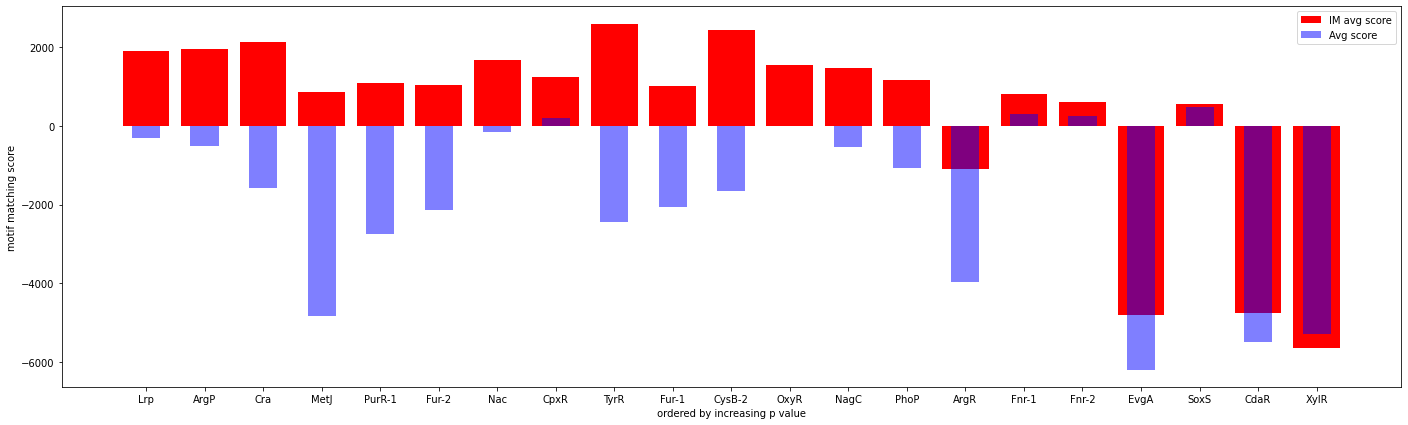

In [26]:
plt.figure(figsize=(24,7))
plt.bar(list(pvalueTable['IM']), list(pvalueTable['IM avg score']), width=0.8, 
        color='r', label='IM avg score')

plt.bar( list(pvalueTable['IM']), list(pvalueTable['avg score']), 
        width=0.6*0.8, color='b', alpha=0.5, label='Avg score')

plt.xticks( list(pvalueTable['IM']) )
plt.ylabel('motif matching score')
plt.xlabel(' ordered by increasing p value ')
plt.legend()
plt.show()

In [27]:
tf_motif_ttest=[]
for name in pwm_db.keys():
    if name == 'Crp':
        tfname = 'CRP'
    elif name == 'Fnr':
        tfname = 'FNR'
    else:
        tfname = name
    d={}
    d['TF'] = name    
    temp = []
    for i in range(len(data_table['gene'])):
        if data_table['gene'][i] in regulon_genes[tfname]:
            temp.append(data_table[name+' score'][i])
    d['Regulon avg score'] = sum(temp)/len(temp)
    d['avg score'] = sum(data_table[name+' score'])/len(data_table[name+' score'])
    d['p value'] = ttest_ind(temp, list(data_table[name+' score'])).pvalue 
    tf_motif_ttest.append(d)
    
pvalTable = pd.DataFrame(tf_motif_ttest)
pvalTable = pvalTable.dropna()
pvalTable = pvalTable.sort_values(by=['p value'])
pvalTable = pvalTable.reset_index()
pvalTable = pvalTable.drop(columns=['index'])
pvalTable

,TF,Regulon avg score,avg score,p value
0,Mlc,17.208000,-1.370723,1.252569e-127
1,PurR,9.592683,-1.242960,1.012670e-106
2,NarP,8.159459,2.757785,5.709479e-97
3,BaeR,17.822222,0.684629,4.525441e-78
4,NarL,5.962424,3.590365,6.727302e-75
5,Fur,5.546277,1.310082,1.141213e-72
6,Crp,5.633333,3.745791,7.547461e-70
7,FadR,7.973529,0.894140,3.568757e-57
8,RutR,7.767857,1.281897,1.477410e-51
9,EvgA,5.987879,-1.298808,6.578273e-48


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


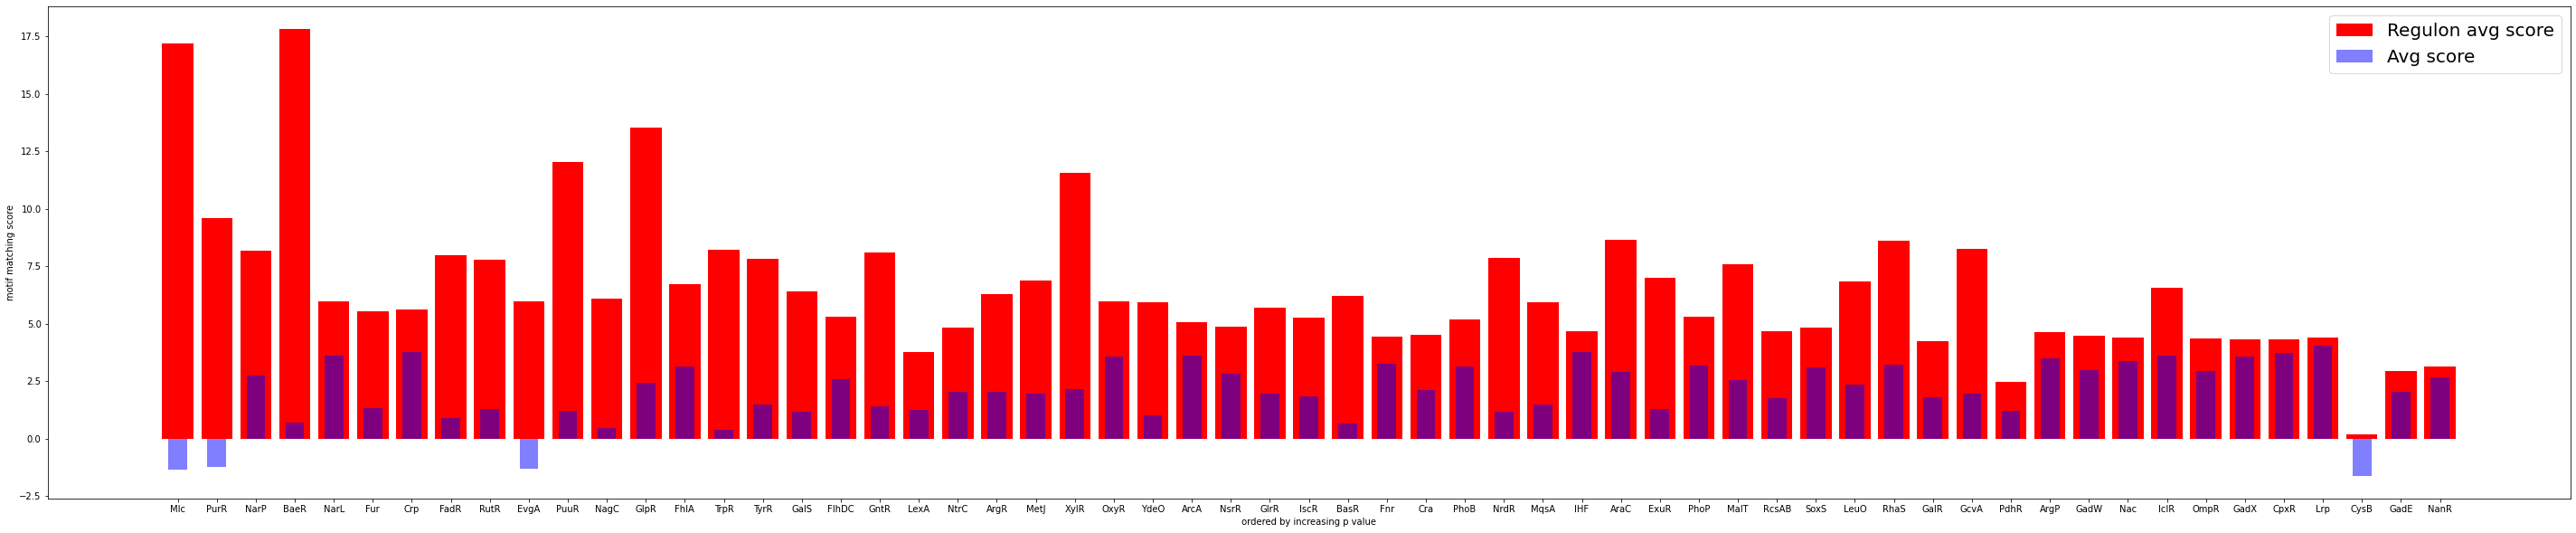

In [28]:
plt.figure(figsize=(50,10))
plt.bar(list(pvalTable['TF']), list(pvalTable['Regulon avg score']), width=0.8, 
        color='r', label='Regulon avg score')

plt.bar( list(pvalTable['TF']), list(pvalTable['avg score']), 
        width=0.6*0.8, color='b', alpha=0.5, label='Avg score')

plt.xticks( list(pvalTable['TF']) )
plt.ylabel('motif matching score')
plt.xlabel(' ordered by increasing p value ')
plt.legend(fontsize = 20)
plt.show()

# ML workflow( if features_avg.csv file exists)

In [13]:
avg_features = pd.read_csv('features_avg.csv')
X = avg_features.iloc[:,1:].values
X = StandardScaler().fit_transform(X)
ID = list(avg_features['ID'])

# generate labels, classify im membership
target_labels={}
for r in IM_genes.keys():
    target_labels[r] = []
    for i in range( len(ID) ):
        if ID[i] in IM_genes[r]:
            target_labels[r].append( 1 )
        else:
            target_labels[r].append( 0 )

### Define Models to Try

In [14]:
y_to_try = {
    'AllR':target_labels['AllR'],
    'ArcA':target_labels['ArcA'],
    'ArgR':target_labels['ArgR'],
    'ArgP':target_labels['ArgP'],
    'BaeR+CpxR':target_labels['BaeR+CpxR'],
    #'BasR':target_labels['BasR'],
    'CpxR':target_labels['CpxR'],
    'CdaR':target_labels['CdaR'],
    'Cra':target_labels['Cra'],
    'Crp-related-2':target_labels['Crp-related-2'],
    'EvgA':target_labels['EvgA'],
    'CysB-1':target_labels['CysB-1'],
    'CysB-2':target_labels['CysB-2'],
    'CysB-3':target_labels['CysB-3'],
    'FadR':target_labels['FadR'],
    'FlhDC-1':target_labels['FlhDC-1'],
    'FlhDC-2':target_labels['FlhDC-2'],
    'Fimbriae':target_labels['Fimbriae']
}

In [15]:
models_to_try = {
    'LR': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        random_state=42
    ),
    'SVM': LinearSVC(
        penalty='l1',
        class_weight='balanced',
        dual=False,
        random_state=42,
        verbose=1
    ),
    'RF': RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        verbose=1
    )
}

In [18]:
result_df = pd.DataFrame(
    columns=['model', 'im', 'train_auc', 'test_auc']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X,
            y= y_labels,
            cv=N_CV,
            scoring='roc_auc',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [y_name] * N_CV,
                'train_auc': cv_result['train_score'],
                'test_auc': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

LR
LR: AllR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   29.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   28.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   22.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   23.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   24.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LR: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   22.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM
SVM: AllR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   10.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   14.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVM: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF
RF: AllR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArcA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: ArgP


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: BaeR+CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CpxR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CdaR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Cra


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Crp-related-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: EvgA


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: CysB-3


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FadR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FlhDC-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: FlhDC-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RF: Fimbriae


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.8s finished


In [19]:
result_df.to_csv('data/model_selection.csv')

In [20]:
result_df = pd.read_csv('data/model_selection.csv')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


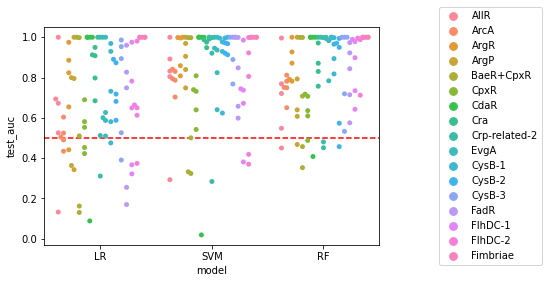

In [21]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='test_auc', data=result_df, hue='im', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))
plt.axhline(y= 0.5, color = 'r', ls = '--')

### Hyperparameter Optimization

In [16]:
hyperopt_models = {
    'LR': {
        'model': LogisticRegression(
            solver='saga',
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'SVM': {
        'model': LinearSVC(
            class_weight='balanced',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'penalty': ['l1', 'l2'],
            'loss': ['hinge', 'squared_hinge'],
            'C': np.arange(0.01, 5, 0.05)
        }
    },
    'RF': {
        'model': RandomForestClassifier(
            class_weight='balanced',
            verbose=1
        ),
        'param_dists': {
            'n_estimators': np.arange(10, 100, 5), # use smaller number of trees to reduce overfit
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [23]:
hyperopt_RF = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RF']['model'],
        hyperopt_models['RF']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RF[y_name] = hyperopt_results_df

AllR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   58.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.2s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   49.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArgP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   56.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


BaeR+CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   48.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.0s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CdaR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   37.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   57.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-related-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   42.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


EvgA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   50.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB-3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   53.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


FadR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   59.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


FlhDC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


FlhDC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   48.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fimbriae
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   43.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.6s finished


In [24]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RF.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_RF_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_RF_df.to_csv('data/hyperopt_RF.csv')

Text(0.5, 1.0, 'RF')

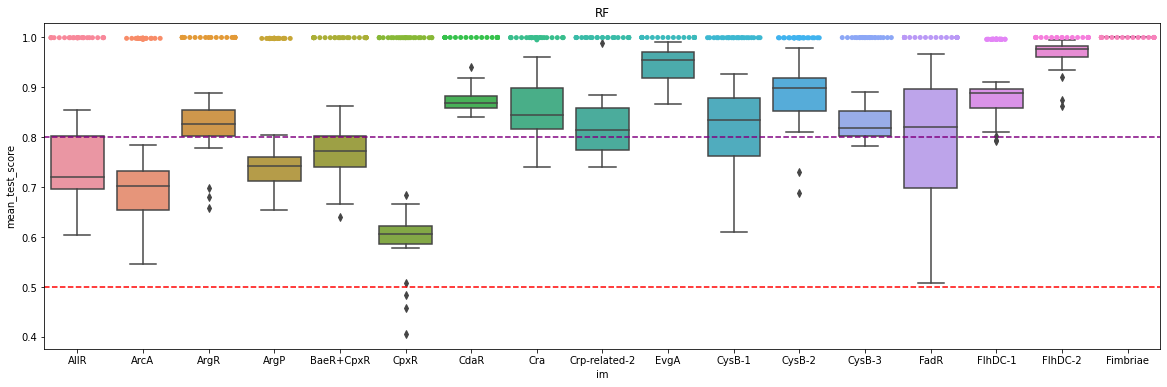

In [27]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_RF.csv' , index_col=0)
plt.figure( figsize=(20,6))
sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.8, color = 'purple', ls = '--')
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.title('RF')

In [17]:
hyperopt_LR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['LR']['model'],
        hyperopt_models['LR']['param_dists'],
        n_iter=25,
        scoring='roc_auc',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_LR[y_name] = hyperopt_results_df

AllR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
ArcA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds
ArgP
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
BaeR+CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
CpxR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds
CdaR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
Cra
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
Crp-related-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  4.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
EvgA
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
CysB-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds
CysB-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds
CysB-3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
FadR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 8 seconds
FlhDC-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 9 seconds
FlhDC-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
Fimbriae
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s finished


In [18]:
# combine all the hyperopt results into a DF
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_LR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)

hyperopt_LR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_LR_df.to_csv('data/hyperopt_LR.csv')

Text(0.5, 1.0, 'LR')

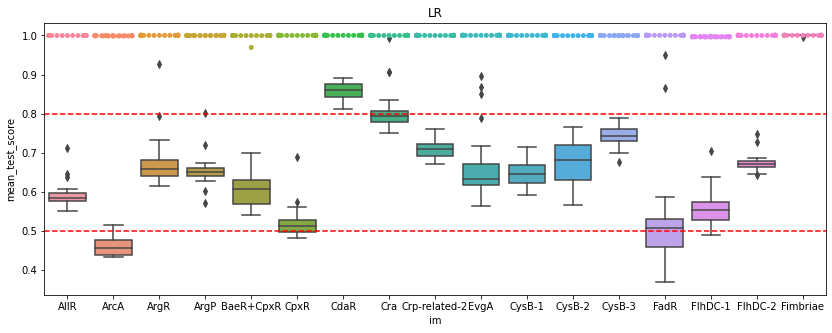

In [21]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_LR.csv' , index_col=0)
plt.figure( figsize=(14,5))
sns.swarmplot(x='im', y='mean_train_score', data=hyperopt_result_df)
sns.boxplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.axhline(y= 0.8, color = 'r', ls = '--')
plt.axhline(y= 0.5, color = 'r', ls = '--')
plt.title('LR')

In [13]:
hyperopt_RF_0 = pd.read_csv( 'data/hyperopt_RF.csv' , index_col=0)
hyperopt_RF_1 = pd.read_csv( 'data/hyperopt_RF_1.csv' , index_col=0)
hyperopt_RF_2 = pd.read_csv( 'data/hyperopt_RF_2.csv' , index_col=0)
hyperopt_RF_3 = pd.read_csv( 'data/hyperopt_RF_3.csv' , index_col=0)
combine_RF = pd.concat([hyperopt_RF_0,hyperopt_RF_1,hyperopt_RF_2,hyperopt_RF_3], axis=0, ignore_index=True)
im = list(np.unique(combine_RF['im']) )
performance = {}
for name in im:
    performance[name] = []
for i in range( len(combine_RF['mean_test_score']) ):
    performance[ combine_RF['im'][i] ].append( combine_RF['mean_test_score'][i] ) 
avg_performance = {}
for name in performance.keys():
    avg_performance[ name ] = sum(  performance[name])/len(  performance[name] )

f1_per = [[],[]]
for i in range( len(regulatory_ims['f1score'])):
    if regulatory_ims.index[i] in avg_performance.keys():
        f1_per[0].append(regulatory_ims['f1score'][i] )
        f1_per[1].append( avg_performance[ regulatory_ims.index[i] ] )
        
size_per = [[],[]]
for i in range( len(regulatory_ims['regulon_size'])):
    if regulatory_ims.index[i] in avg_performance.keys():
        size_per[0].append(regulatory_ims['regulon_size'][i] )
        size_per[1].append( avg_performance[ regulatory_ims.index[i] ] )

Text(0, 0.5, 'Performance(ROC)')

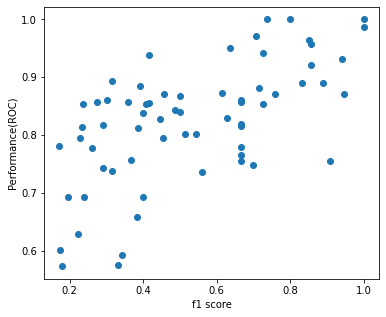

In [14]:
plt.figure(figsize=(6,5))
plt.scatter(f1_per[0],f1_per[1])
plt.xlabel('f1 score')
plt.ylabel('Performance(ROC)')

Text(0, 0.5, 'Performance(ROC)')

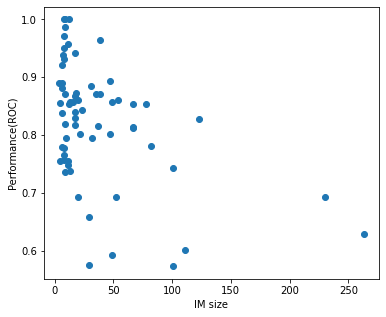

In [15]:
plt.figure(figsize=(6,5))
plt.scatter(size_per[0],size_per[1])
plt.xlabel('IM size')
plt.ylabel('Performance(ROC)')